Import Libraries

In [1]:
import sys
import pandas as pd
import numpy as np
import scipy as sp              #collection of functions for scientific computing and advance mathematics
from IPython import display     #pretty printing of dataframes in Jupyter notebook
import random
import time
# #ignore warnings
# import warnings
# warnings.filterwarnings('ignore')


#Common Model Algorithms
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier

#Common Model Helpers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn import feature_selection
from sklearn.model_selection import train_test_split, cross_validate, ShuffleSplit
from sklearn import metrics

#Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from pandas.plotting import scatter_matrix

#Configure Visualization Defaults
#%matplotlib inline = show plots in Jupyter Notebook browser
%matplotlib inline
# mpl.style.use('ggplot')
# sns.set_style('white')
# pylab.rcParams['figure.figsize'] = 12,8

1. The `Survived` variable is our outcome or dependent variable. It is a binary nominal datatype of 1 for survived and 0 for did not survive. All other variables are potential predictor or independent variables. It's important to note, more predictor variables do not make a better model, but the right variables. 

2. The `PassengerID` and `Ticket` variables are assumed to be random unique identifiers, that have no impact on the outcome variable. Thus, they will be excluded from analysis.  

3. The `Pclass` variable is an ordinal datatype for the ticket class, a proxy for socio-economic status (SES), representing 1 = upper class, 2 = middle class, and 3 = lower class.  

4. The `Name` variable is a nominal datatype. It could be used in feature engineering to derive the gender from title, family size from surname, and SES from titles like doctor or master. Since these variables already exist, we'll make use of it to see if title, like master, makes a difference.  

5. The `Sex` and `Embarked` variables are a nominal datatype. They will be converted to dummy variables for mathematical calculations.  

6. The `Age` and `Fare` variable are continuous quantitative datatypes.  

7. The `SibSp` represents number of related siblings/spouse aboard and `Parch` represents number of related parents/children aboard. Both are discrete quantitative datatypes. This can be used for feature engineering to create a family size and is alone variable.  

8. The `Cabin` variable is a nominal datatype that can be used in feature engineering for approximate position on ship when the incident occurred and SES from deck levels. However, since there are many null values, it does not add value and thus is excluded from analysis.  

In [2]:
raw_data = pd.read_csv(r"E:\github\data science projects\Titanic_Disaster\train.csv")
data_val = pd.read_csv(r"E:\github\data science projects\Titanic_Disaster\test.csv")

#to play with our data we'll create a copy
data1 = raw_data.copy(deep=True)

# we can clean both datasets at once
data_cleaner = [data1, data_val]

print(data1.info())
data1.sample(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
247,248,1,2,"Hamalainen, Mrs. William (Anna)",female,24.0,0,2,250649,14.5000,NaN,S
465,466,0,3,"Goncalves, Mr. Manuel Estanslas",male,38.0,0,0,SOTON/O.Q. 3101306,7.0500,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
407,408,1,2,"Richards, Master. William Rowe",male,3.0,1,1,29106,18.7500,NaN,S
845,846,0,3,"Abbing, Mr. Anthony",male,42.0,0,0,C.A. 5547,7.5500,NaN,S
413,414,0,2,"Cunningham, Mr. Alfred Fleming",male,NaN,0,0,239853,0.0000,NaN,S
346,347,1,2,"Smith, Miss. Marion Elsie",female,40.0,0,0,31418,13.0000,NaN,S
130,131,0,3,"Drazenoic, Mr. Jozef",male,33.0,0,0,349241,7.8958,NaN,C
720,721,1,2,"Harper, Miss. Annie Jessie ""Nina""",female,6.0,0,1,248727,33.0000,NaN,S
526,527,1,2,"Ridsdale, Miss. Lucy",female,50.0,0,0,W./C. 14258,10.5000,NaN,S


 The 4 C's of Data Cleaning: Correcting, Completing, Creating, and Converting

1. `Correcting`: Reviewing the data, there does not appear to be any aberrant or non-acceptable data inputs. In addition, we see we may have potential outliers in age and fare. However, since they are reasonable values, we will wait until after we complete our exploratory analysis to determine if we should include or exclude from the dataset. It should be noted, that if they were unreasonable values, for example age = 800 instead of 80, then it's probably a safe decision to fix now. However, we want to use caution when we modify data from its original value, because it may be necessary to create an accurate model.  

2. `Completing`: There are null values or missing data in the age, cabin, and embarked field. Missing values can be bad, because some algorithms don't know how-to handle null values and will fail. While others, like decision trees, can handle null values. Thus, it's important to fix before we start modeling, because we will compare and contrast several models. There are two common methods, either delete the record or populate the missing value using a reasonable input. It is not recommended to delete the record, especially a large percentage of records, unless it truly represents an incomplete record. Instead, it's best to impute missing values. A basic methodology for qualitative data is impute using mode. A basic methodology for quantitative data is impute using mean, median, or mean + randomized standard deviation. An intermediate methodology is to use the basic methodology based on specific criteria; like the average age by class or embark port by fare and SES. There are more complex methodologies, however before deploying, it should be compared to the base model to determine if complexity truly adds value. For this dataset, age will be imputed with the median, the cabin attribute will be dropped, and embark will be imputed with mode. Subsequent model iterations may modify this decision to determine if it improves the model’s accuracy.  

3. `Creating`: Feature engineering is when we use existing features to create new features to determine if they provide new signals to predict our outcome. For this dataset, we will create a title feature to determine if it played a role in survival.  

4. `Converting`: Last, but certainly not least, we'll deal with formatting. There are no date or currency formats, but datatype formats. Our categorical data imported as objects, which makes it difficult for mathematical calculations. For this dataset, we will convert object datatypes to categorical dummy variables.


In [3]:
print('Train columns with null values:\n', data1.isnull().sum(), "\n"*2)


print('Test/Validation columns with null values:\n', data_val.isnull().sum())


data1.describe(include="all")

Train columns with null values:
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64 


Test/Validation columns with null values:
 PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Braund, Mr. Owen Harris",male,NaN,NaN,NaN,347082,NaN,B96 B98,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [4]:
# COMPLETING: complete or delete missing values in train and test/validation dataset
for dataset in data_cleaner:
    dataset["Age"].fillna(dataset["Age"].median(), inplace=True)
    dataset["Embarked"].fillna(dataset["Embarked"].mode()[0], inplace=True)
    dataset["Fare"].fillna(dataset["Fare"].median(), inplace=True)
    
drop_column = ['PassengerId','Cabin', 'Ticket']
data1.drop(drop_column, axis=1, inplace=True)

print(data1.isnull().sum())
print("-"*10)
print(data_val.isnull().sum())

Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64
----------
PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
dtype: int64


In [5]:
# CREATE: Feature Engineering for train and test/validation dataset
for dataset in data_cleaner:
    dataset["FamilySize"] = dataset ['SibSp'] + dataset['Parch'] + 1
    
    dataset['IsAlone'] = 1 #initialize to yes/1 is alone
    dataset['IsAlone'].loc[dataset['FamilySize'] > 1] = 0 # now update to no/0 if family size is greater than 1

    #quick and dirty code split title from name: http://www.pythonforbeginners.com/dictionary/python-split
    # also can use this code:  pd.Series([i.split(",")[1].split(".")[0] for i in dataset["Name"]])
    dataset['Title'] = dataset['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]

    #Fare Bins/Buckets using qcut or frequency bins: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.qcut.html
    dataset['FareBin'] = pd.qcut(dataset['Fare'], 4)

    #Age Bins/Buckets using cut or value bins
    dataset['AgeBin'] = pd.cut(dataset['Age'].astype(int), 5)

#cleanup rare title names
#print(data1['Title'].value_counts())
stat_min = 10 #while small is arbitrary, we'll use the common minimum in statistics: http://nicholasjjackson.com/2012/03/08/sample-size-is-10-a-magic-number/
title_names = (data1['Title'].value_counts() < stat_min) #this will create a true false series with title name as index

#apply and lambda functions are quick and dirty code to find and replace with fewer lines of code: https://community.modeanalytics.com/python/tutorial/pandas-groupby-and-python-lambda-functions/
data1['Title'] = data1['Title'].apply(lambda x: 'Misc' if title_names.loc[x] == True else x)
print(data1['Title'].value_counts())
print("-"*10)


#preview data again
data1.info()
data_val.info()
data1.sample(10)

Title
Mr        517
Miss      182
Mrs       125
Master     40
Misc       27
Name: count, dtype: int64
----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   Survived    891 non-null    int64   
 1   Pclass      891 non-null    int64   
 2   Name        891 non-null    object  
 3   Sex         891 non-null    object  
 4   Age         891 non-null    float64 
 5   SibSp       891 non-null    int64   
 6   Parch       891 non-null    int64   
 7   Fare        891 non-null    float64 
 8   Embarked    891 non-null    object  
 9   FamilySize  891 non-null    int64   
 10  IsAlone     891 non-null    int64   
 11  Title       891 non-null    object  
 12  FareBin     891 non-null    category
 13  AgeBin      891 non-null    category
dtypes: category(2), float64(2), int64(6), object(4)
memory usage: 85.9+ KB
<class 'pandas.core.frame.DataFram

C:\Users\MR-14\AppData\Local\Temp\ipykernel_13144\2867827060.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['IsAlone'].loc[dataset['FamilySize'] > 1] = 0 # now update to no/0 if family size is greater than 1
C:\Users\MR-14\AppData\Local\Temp\ipykernel_13144\2867827060.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['IsAlone'].loc[dataset['FamilySize'] > 1] = 0 # now update to no/0 if family size is greater than 1


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,IsAlone,Title,FareBin,AgeBin
117,0,2,"Turpin, Mr. William John Robert",male,29.0,1,0,21.0000,S,2,0,Mr,"(14.454, 31.0]","(16.0, 32.0]"
244,0,3,"Attalah, Mr. Sleiman",male,30.0,0,0,7.2250,C,1,1,Mr,"(-0.001, 7.91]","(16.0, 32.0]"
232,0,2,"Sjostedt, Mr. Ernst Adolf",male,59.0,0,0,13.5000,S,1,1,Mr,"(7.91, 14.454]","(48.0, 64.0]"
360,0,3,"Skoog, Mr. Wilhelm",male,40.0,1,4,27.9000,S,6,0,Mr,"(14.454, 31.0]","(32.0, 48.0]"
449,1,1,"Peuchen, Major. Arthur Godfrey",male,52.0,0,0,30.5000,S,1,1,Misc,"(14.454, 31.0]","(48.0, 64.0]"
382,0,3,"Tikkanen, Mr. Juho",male,32.0,0,0,7.9250,S,1,1,Mr,"(7.91, 14.454]","(16.0, 32.0]"
35,0,1,"Holverson, Mr. Alexander Oskar",male,42.0,1,0,52.0000,S,2,0,Mr,"(31.0, 512.329]","(32.0, 48.0]"
452,0,1,"Foreman, Mr. Benjamin Laventall",male,30.0,0,0,27.7500,C,1,1,Mr,"(14.454, 31.0]","(16.0, 32.0]"
361,0,2,"del Carlo, Mr. Sebastiano",male,29.0,1,0,27.7208,C,2,0,Mr,"(14.454, 31.0]","(16.0, 32.0]"
122,0,2,"Nasser, Mr. Nicholas",male,32.5,1,0,30.0708,C,2,0,Mr,"(14.454, 31.0]","(16.0, 32.0]"


In [6]:
#CONVERT: convert objects to category using Label Encoder for train and test/validation dataset

#code categorical data
label = LabelEncoder()
for dataset in data_cleaner:    
    dataset['Sex_Code'] = label.fit_transform(dataset['Sex'])
    dataset['Embarked_Code'] = label.fit_transform(dataset['Embarked'])
    dataset['Title_Code'] = label.fit_transform(dataset['Title'])
    dataset['AgeBin_Code'] = label.fit_transform(dataset['AgeBin'])
    dataset['FareBin_Code'] = label.fit_transform(dataset['FareBin'])


#define y variable aka target/outcome
Target = ['Survived']

#define x variables for original features aka feature selection
data1_x = ['Sex','Pclass', 'Embarked', 'Title','SibSp', 'Parch', 'Age', 'Fare', 'FamilySize', 'IsAlone'] #pretty name/values for charts
data1_x_calc = ['Sex_Code','Pclass', 'Embarked_Code', 'Title_Code','SibSp', 'Parch', 'Age', 'Fare'] #coded for algorithm calculation
data1_xy =  Target + data1_x
print('Original X Y: ', data1_xy, '\n')


#define x variables for original w/bin features to remove continuous variables
data1_x_bin = ['Sex_Code','Pclass', 'Embarked_Code', 'Title_Code', 'FamilySize', 'AgeBin_Code', 'FareBin_Code']
data1_xy_bin = Target + data1_x_bin
print('Bin X Y: ', data1_xy_bin, '\n')


#define x and y variables for dummy features original
data1_dummy = pd.get_dummies(data1[data1_x], dtype=float)
data1_x_dummy = data1_dummy.columns.tolist()
data1_xy_dummy = Target + data1_x_dummy
print('Dummy X Y: ', data1_xy_dummy, '\n')


data1_dummy.head()

Original X Y:  ['Survived', 'Sex', 'Pclass', 'Embarked', 'Title', 'SibSp', 'Parch', 'Age', 'Fare', 'FamilySize', 'IsAlone'] 

Bin X Y:  ['Survived', 'Sex_Code', 'Pclass', 'Embarked_Code', 'Title_Code', 'FamilySize', 'AgeBin_Code', 'FareBin_Code'] 

Dummy X Y:  ['Survived', 'Pclass', 'SibSp', 'Parch', 'Age', 'Fare', 'FamilySize', 'IsAlone', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Title_Master', 'Title_Misc', 'Title_Miss', 'Title_Mr', 'Title_Mrs'] 



,Pclass,SibSp,Parch,Age,Fare,FamilySize,IsAlone,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Misc,Title_Miss,Title_Mr,Title_Mrs
0,3,1,0,22.0,7.2500,2,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,1,1,0,38.0,71.2833,2,0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,3,0,0,26.0,7.9250,1,1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,1,1,0,35.0,53.1000,2,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,3,0,0,35.0,8.0500,1,1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [7]:
#split train and test data with function defaults

train1_x, test1_x, train1_y, test1_y = train_test_split(data1[data1_x_calc], data1[Target], random_state = 0)
train1_x_bin, test1_x_bin, train1_y_bin, test1_y_bin = train_test_split(data1[data1_x_bin], data1[Target] , random_state = 0)
train1_x_dummy, test1_x_dummy, train1_y_dummy, test1_y_dummy = train_test_split(data1_dummy[data1_x_dummy], data1[Target], random_state = 0)


print(f"Data1 Shape: {data1.shape}")
print(f"Train1 Shape: {train1_x.shape}")
print(f"Test1 Shape: {test1_x.shape}")

train1_x_bin.head()

Data1 Shape: (891, 19)
Train1 Shape: (668, 8)
Test1 Shape: (223, 8)


,Sex_Code,Pclass,Embarked_Code,Title_Code,FamilySize,AgeBin_Code,FareBin_Code
105,1,3,2,3,1,1,0
68,0,3,2,2,7,1,1
253,1,3,2,3,2,1,2
320,1,3,2,3,1,1,0
706,0,2,2,4,1,2,1


In [8]:
# Perform Exploratory Analysis with Statistics

#Discrete Variable Correlation by Survival using
#group by aka pivot table
for x in data1_x:
    if data1[x].dtype != 'float64' :
        print('Survival Correlation by:', x)
        print(data1[[x, Target[0]]].groupby(x, as_index=False).mean())
        print('-'*10, '\n')


#using crosstabs
# print(pd.crosstab(data1['Title'],data1[Target[0]]))

Survival Correlation by: Sex
      Sex  Survived
0  female  0.742038
1    male  0.188908
---------- 

Survival Correlation by: Pclass
   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363
---------- 

Survival Correlation by: Embarked
  Embarked  Survived
0        C  0.553571
1        Q  0.389610
2        S  0.339009
---------- 

Survival Correlation by: Title
    Title  Survived
0  Master  0.575000
1    Misc  0.444444
2    Miss  0.697802
3      Mr  0.156673
4     Mrs  0.792000
---------- 

Survival Correlation by: SibSp
   SibSp  Survived
0      0  0.345395
1      1  0.535885
2      2  0.464286
3      3  0.250000
4      4  0.166667
5      5  0.000000
6      8  0.000000
---------- 

Survival Correlation by: Parch
   Parch  Survived
0      0  0.343658
1      1  0.550847
2      2  0.500000
3      3  0.600000
4      4  0.000000
5      5  0.200000
6      6  0.000000
---------- 

Survival Correlation by: FamilySize
   FamilySize  Survived
0           1  0.303538
1 

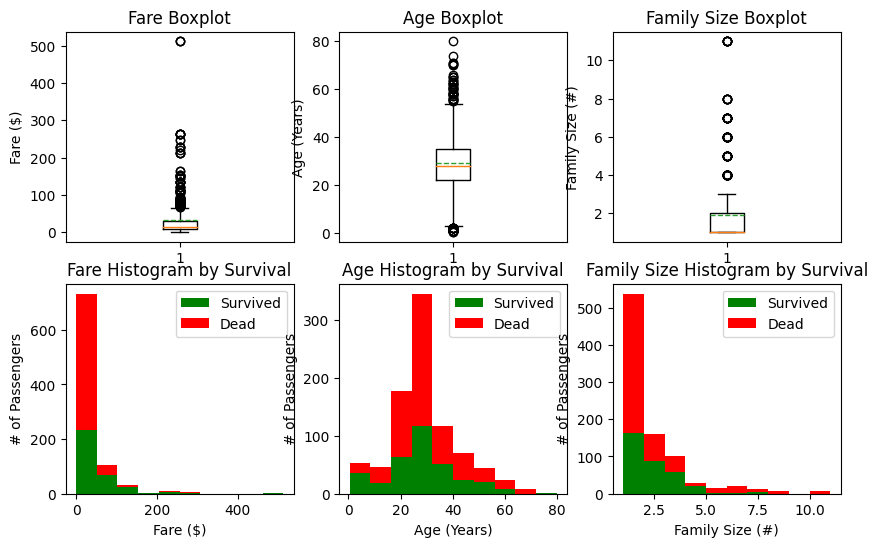

In [9]:
#graph distribution of quantitative data
plt.figure(figsize=[10,6])

plt.subplot(231)
plt.boxplot(x=data1['Fare'], showmeans = True, meanline = True)
plt.title('Fare Boxplot')
plt.ylabel('Fare ($)')

plt.subplot(232)
plt.boxplot(data1['Age'], showmeans = True, meanline = True)
plt.title('Age Boxplot')
plt.ylabel('Age (Years)')

plt.subplot(233)
plt.boxplot(data1['FamilySize'], showmeans = True, meanline = True)
plt.title('Family Size Boxplot')
plt.ylabel('Family Size (#)')

plt.subplot(234)
plt.hist(x = [data1[data1['Survived']==1]['Fare'], data1[data1['Survived']==0]['Fare']], 
         stacked=True, color = ['g','r'],label = ['Survived','Dead'])
plt.title('Fare Histogram by Survival')
plt.xlabel('Fare ($)')
plt.ylabel('# of Passengers')
plt.legend()

plt.subplot(235)
plt.hist(x = [data1[data1['Survived']==1]['Age'], data1[data1['Survived']==0]['Age']], 
         stacked=True, color = ['g','r'],label = ['Survived','Dead'])
plt.title('Age Histogram by Survival')
plt.xlabel('Age (Years)')
plt.ylabel('# of Passengers')
plt.legend()

plt.subplot(236)
plt.hist(x = [data1[data1['Survived']==1]['FamilySize'], data1[data1['Survived']==0]['FamilySize']], 
         stacked=True, color = ['g','r'],label = ['Survived','Dead'])
plt.title('Family Size Histogram by Survival')
plt.xlabel('Family Size (#)')
plt.ylabel('# of Passengers')
plt.legend()

<Axes: xlabel='FamilySize', ylabel='Survived'>

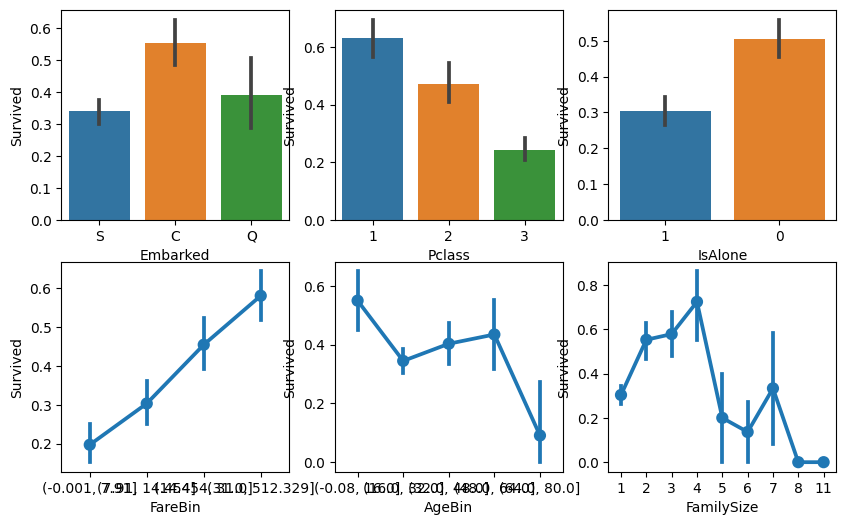

In [10]:
#we will use seaborn graphics for multi-variable comparison
#graph individual features by survival

fig, axis = plt.subplots(2, 3,figsize=(10,6))

sns.barplot(x = 'Embarked', y = 'Survived', data=data1, ax = axis[0,0])
sns.barplot(x = 'Pclass', y = 'Survived', order=[1,2,3], data=data1, ax = axis[0,1])
sns.barplot(x = 'IsAlone', y = 'Survived', order=[1,0], data=data1, ax = axis[0,2])

sns.pointplot(x = 'FareBin', y = 'Survived',  data=data1, ax = axis[1,0])
sns.pointplot(x = 'AgeBin', y = 'Survived',  data=data1, ax = axis[1,1])
sns.pointplot(x = 'FamilySize', y = 'Survived', data=data1, ax = axis[1,2])

Text(0.5, 1.0, 'Pclass vs Family Size Survival Comparison')

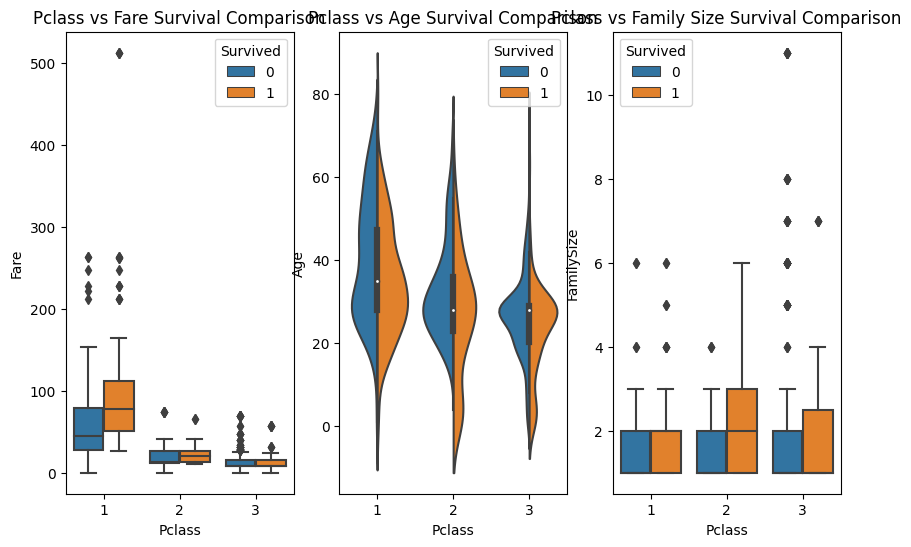

In [11]:
#graph distribution of qualitative data: Pclass
#we know class mattered in survival, now let's compare class and a 2nd feature
fig, (axis1,axis2,axis3) = plt.subplots(1,3,figsize=(10,6))

sns.boxplot(x = 'Pclass', y = 'Fare', hue = 'Survived', data = data1, ax = axis1)
axis1.set_title('Pclass vs Fare Survival Comparison')

sns.violinplot(x = 'Pclass', y = 'Age', hue = 'Survived', data = data1, split = True, ax = axis2)
axis2.set_title('Pclass vs Age Survival Comparison')

sns.boxplot(x = 'Pclass', y ='FamilySize', hue = 'Survived', data = data1, ax = axis3)
axis3.set_title('Pclass vs Family Size Survival Comparison')

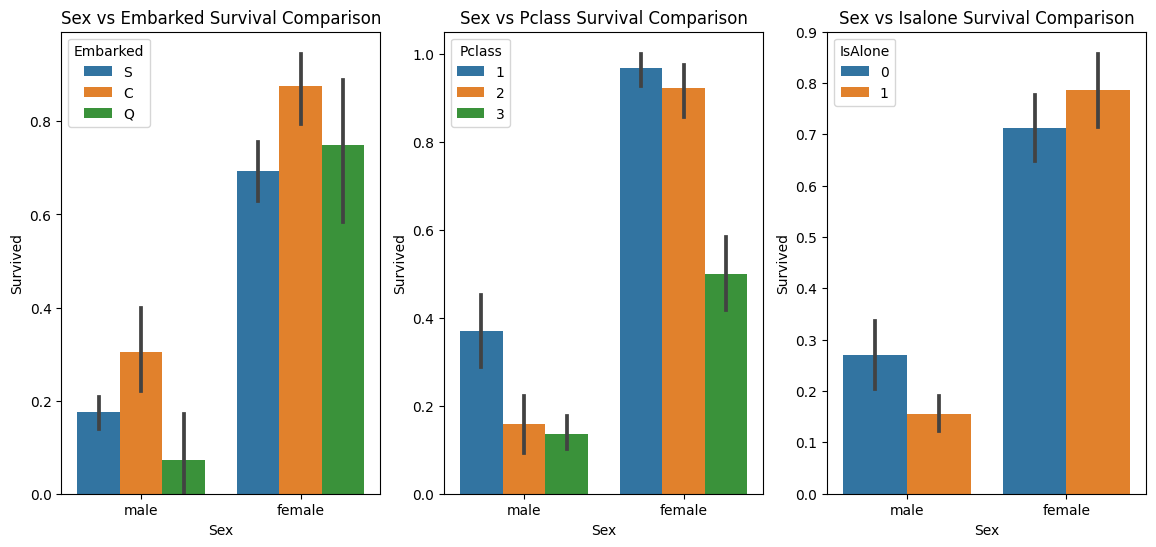

In [12]:
#graph distribution of qualitative data: Sex
#we know sex mattered in survival, now let's compare sex and a 2nd feature
fig, qaxis = plt.subplots(1, 3, figsize=(14, 6))

labels = ['Embarked', 'Pclass', 'IsAlone']

for i in range(3):
    sns.barplot(x='Sex', y='Survived', hue=labels[i], data=data1, ax=qaxis[i])
    qaxis[i].set_title(f'Sex vs {labels[i].capitalize()} Survival Comparison')

In [13]:
data1.groupby(['Sex', 'Embarked'])['Survived'].mean().to_frame()

Survived
Sex    Embarked          
female C         0.876712
       Q         0.750000
       S         0.692683
male   C         0.305263
       Q         0.073171
       S         0.174603

In [14]:
data1['Age'][data1['Survived']==1]

1      38.0
2      26.0
3      35.0
8      27.0
9      14.0
       ... 
875    15.0
879    56.0
880    25.0
887    19.0
889    26.0
Name: Age, Length: 342, dtype: float64

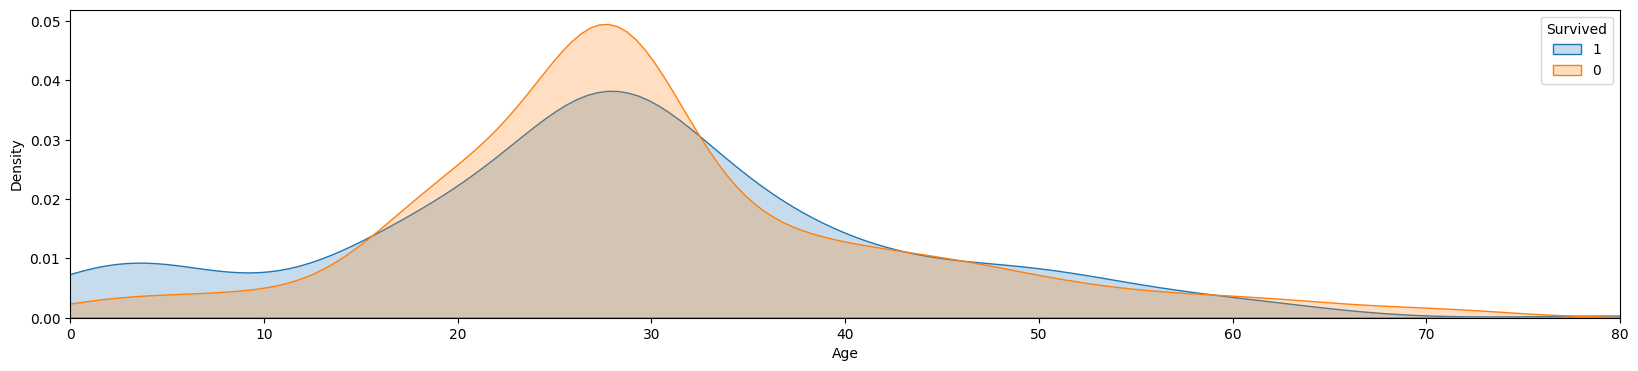

In [15]:
#plot distributions of age of passengers who survived or did not survive

plt.figure(figsize=(20,4))
sns.kdeplot(data1['Age'][data1['Survived']==1], fill=True)
sns.kdeplot(data1['Age'][data1['Survived']==0], fill=True)
plt.xlim(0 , data1['Age'].max())
plt.legend(['1','0'], title='Survived')

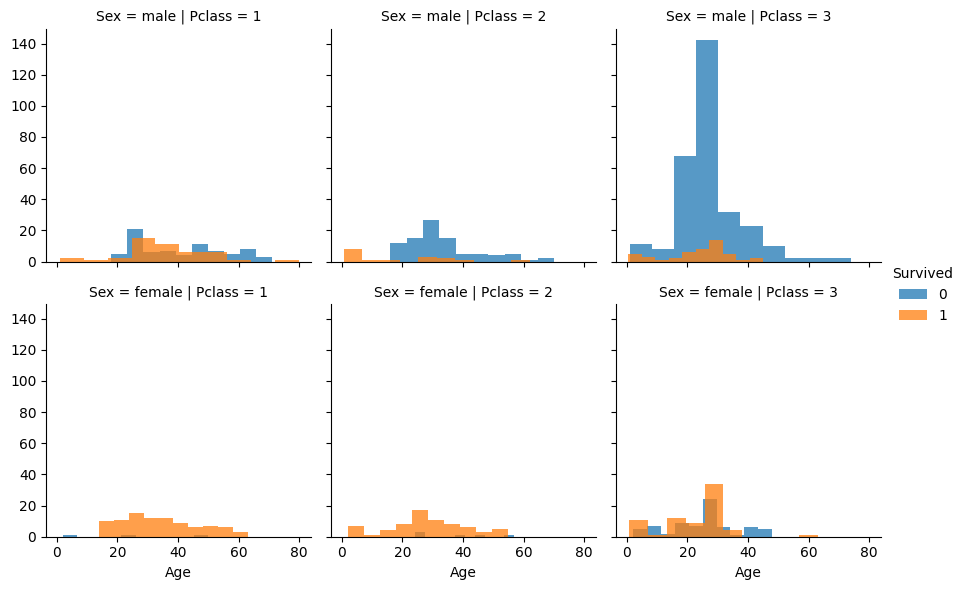

In [16]:
h = sns.FacetGrid(data1, row = 'Sex', col = 'Pclass', hue = 'Survived')
h.map(plt.hist, 'Age', alpha = .75)
h.add_legend()

<Axes: >

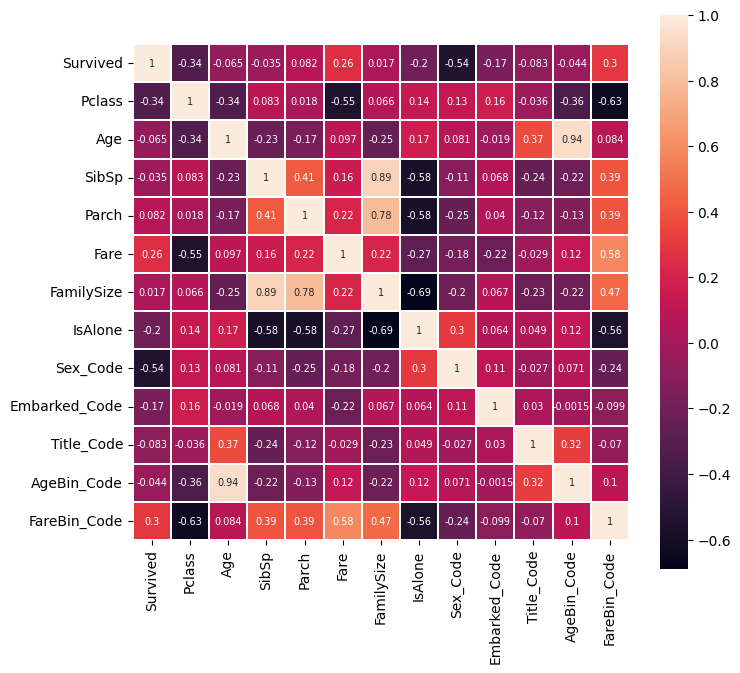

In [17]:
corr = data1.drop(columns=['Name', 'Title',	'FareBin',	'AgeBin', 'Embarked', 'Sex']).corr()
plt.figure(figsize=(8, 8))
sns.heatmap(corr, square=True, 
        cbar_kws={'shrink':.9 },
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':7 })

Model Data

In [35]:
MLA = [
    #Ensemble Methods
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),

    #Gaussian Processes
    gaussian_process.GaussianProcessClassifier(),
    
    #GLM
    linear_model.LogisticRegressionCV(),
    linear_model.PassiveAggressiveClassifier(),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),
    
    #Navies Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    
    #Nearest Neighbor
    neighbors.KNeighborsClassifier(),
    
    #SVM
    svm.SVC(probability=True),
    svm.NuSVC(probability=True),
    svm.LinearSVC(),
    
    #Trees    
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),
    
    #Discriminant Analysis
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis(),

    
    #xgboost
    XGBClassifier()    
    ]


#split dataset in cross-validation with this splitter
#note: this is an alternative to train_test_split
cv_split = ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0 ) # run model 10x with 60/30 split intentionally leaving out 10%

#create table to compare MLA metrics
MLA_columns = ['MLA Name', 'MLA Parameters','MLA Train Accuracy Mean', 'MLA Test Accuracy Mean', 'MLA Test Accuracy 3*STD' ,'MLA Time']
MLA_compare = pd.DataFrame(columns = MLA_columns)

#create table to compare MLA predictions
MLA_predict = data1[Target]

#index through MLA and save performance to table
row_index = 0
for alg in MLA:

    #set name and parameters
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())
    
    #score model with cross validation: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate
    cv_results = cross_validate(alg, data1[data1_x_bin], data1["Survived"], cv  = cv_split, return_train_score=True)

    MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
    MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()   
    #if this is a non-bias random sample, then +/-3 standard deviations (std) from the mean, should statistically capture 99.7% of the subsets
    MLA_compare.loc[row_index, 'MLA Test Accuracy 3*STD'] = cv_results['test_score'].std()*3   #let's know the worst that can happen!
    

    #save MLA predictions - see section 6 for usage
    alg.fit(data1[data1_x_bin], data1["Survived"])
    MLA_predict[MLA_name] = alg.predict(data1[data1_x_bin])
    
    row_index+=1


#print and sort table: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sort_values.html
MLA_compare.sort_values(by = ['MLA Test Accuracy Mean'], ascending = False, inplace = True)
MLA_compare
#MLA_predict

C:\Users\MR-14\AppData\Local\Temp\ipykernel_13144\864625352.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MLA_predict[MLA_name] = alg.predict(data1[data1_x_bin])
C:\Users\MR-14\AppData\Local\Temp\ipykernel_13144\864625352.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MLA_predict[MLA_name] = alg.predict(data1[data1_x_bin])
C:\Users\MR-14\AppData\Local\Temp\ipykernel_13144\864625352.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

,MLA Name,MLA Parameters,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Test Accuracy 3*STD,MLA Time
14,SVC,"{'C': 1.0, 'break_ties': False, 'cache_size': ...",0.835206,0.827612,0.040916,0.058263
4,RandomForestClassifier,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",0.895131,0.827239,0.062536,0.197033
21,XGBClassifier,"{'objective': 'binary:logistic', 'base_score':...",0.890824,0.826866,0.054656,0.138182
15,NuSVC,"{'break_ties': False, 'cache_size': 200, 'clas...",0.834082,0.826119,0.045663,0.070756
2,ExtraTreesClassifier,"{'bootstrap': False, 'ccp_alpha': 0.0, 'class_...",0.895131,0.824254,0.0612,0.153405
1,BaggingClassifier,"{'base_estimator': 'deprecated', 'bootstrap': ...",0.890637,0.823881,0.061271,0.03031
3,GradientBoostingClassifier,"{'ccp_alpha': 0.0, 'criterion': 'friedman_mse'...",0.866667,0.822761,0.049873,0.13257
17,DecisionTreeClassifier,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit...",0.895131,0.822015,0.052517,0.003898
0,AdaBoostClassifier,"{'algorithm': 'SAMME.R', 'base_estimator': 'de...",0.820412,0.81194,0.049861,0.107133
5,GaussianProcessClassifier,"{'copy_X_train': True, 'kernel': None, 'max_it...",0.871723,0.810448,0.049254,0.199338


Text(0, 0.5, 'Algorithm')

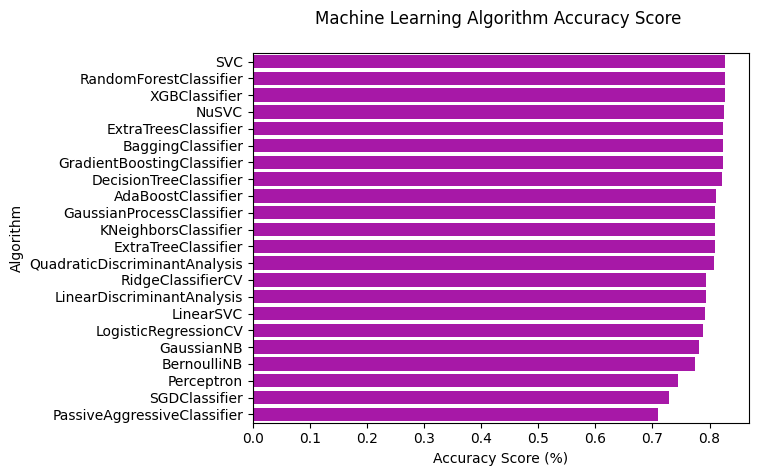

In [36]:
sns.barplot(x='MLA Test Accuracy Mean', y = 'MLA Name', data = MLA_compare, color = 'm')

#prettify using pyplot: https://matplotlib.org/api/pyplot_api.html
plt.title('Machine Learning Algorithm Accuracy Score \n')
plt.xlabel('Accuracy Score (%)')
plt.ylabel('Algorithm')